### Import Libraries

In [1]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D,  BatchNormalization, Add, Activation, MaxPooling2D, concatenate, Flatten, Dense, AveragePooling2D,Dropout
from keras.optimizers import Adam
from keras.models import Sequential
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import layers, Sequential
from keras import applications 
from tensorflow.keras.optimizers import SGD
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


### Data Visualization

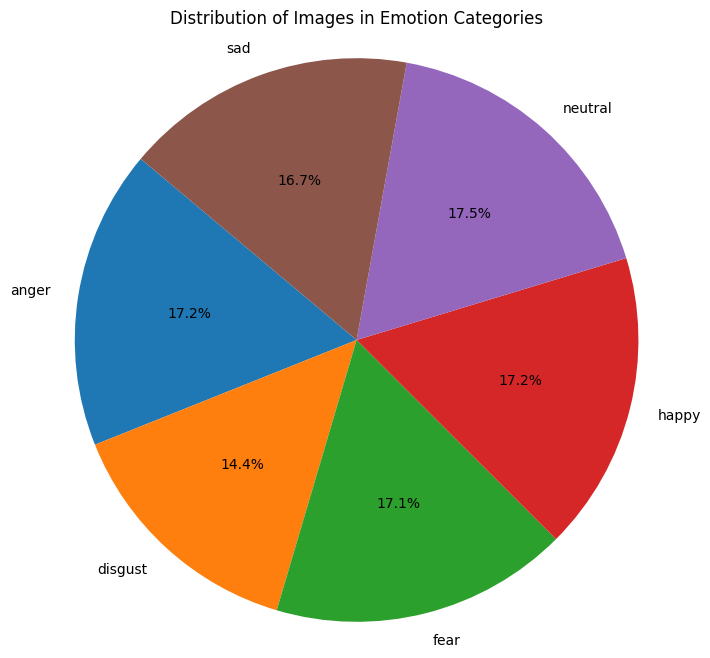

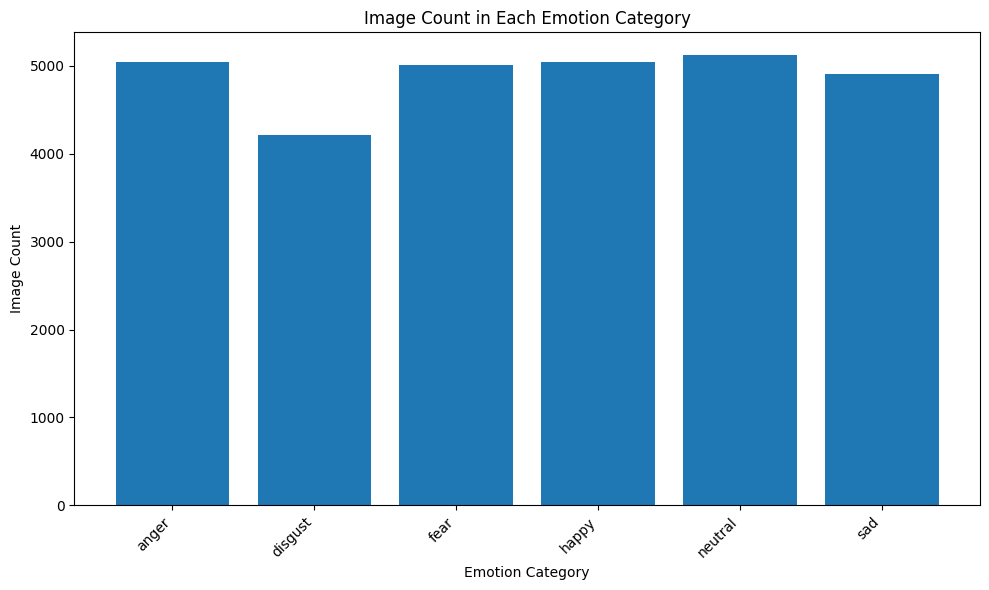

In [2]:
import os
import matplotlib.pyplot as plt

# Define the root directory containing the "Emotions" folder
root_directory = 'Emotions'

# Function to count the number of image files in a folder
def count_images_in_folder(folder_path):
    image_extensions = ['jpg', 'jpeg', 'png', 'gif']  
    count = sum(1 for file in os.listdir(folder_path) if file.lower().endswith(tuple(image_extensions)))
    return count

# Initialize lists to store folder names and corresponding image counts
folder_names = []
image_counts = []

# Iterate through the emotion categories (subfolders) in the "Emotions" folder
for emotion_folder in os.listdir(root_directory):
    emotion_folder_path = os.path.join(root_directory, emotion_folder)
    if os.path.isdir(emotion_folder_path):
        folder_names.append(emotion_folder)
        image_count = count_images_in_folder(emotion_folder_path)
        image_counts.append(image_count)

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(image_counts, labels=folder_names, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images in Emotion Categories')
plt.axis('equal')  

plt.show()

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(folder_names, image_counts)
plt.xlabel('Emotion Category')
plt.ylabel('Image Count')
plt.title('Image Count in Each Emotion Category')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


### Load Dataset

In [3]:

dataset_folder = 'Emotions'

# List of class names
class_names = ['anger', 'disgust', 'fear', 'happy', 'neutral','sad']

# Load images
data = []
labels = []

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_folder, class_name)
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        img = Image.open(img_path)
        img = img.resize((80, 80))
        img_array = np.array(img)
        data.append(img_array)
        labels.append(class_idx)

### Preprocess Data

In [4]:
# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training, validation, and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [5]:
# Print the shapes of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape", x_val.shape)
print("y_val shape :", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (18786, 80, 80, 3)
y_train shape: (18786,)
x_val shape (4697, 80, 80, 3)
y_val shape : (4697,)
x_test shape: (5871, 80, 80, 3)
y_test shape: (5871,)


In [6]:
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

In [7]:
# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, 6)
y_val = keras.utils.to_categorical(y_val, 6)
y_test = keras.utils.to_categorical(y_test, 6)

In [8]:
checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)
early_stopping=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)

### Deep Learning Model - CNN

In [9]:
#custom Model
customModel = Sequential()
customModel=Sequential(
    [
        layers.Conv2D(512,3,input_shape=(80,80,3),padding='same',activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(256,3,padding='same',activation='relu'),
        layers.Conv2D(256,3,padding='same',activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(128,3,padding='same',activation='relu'),
        layers.Conv2D(128,3,padding='same',activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(64,3,padding='same',activation='relu'),
        layers.Conv2D(64,3,padding='same',activation='relu'),
        layers.BatchNormalization(),        
        layers.MaxPooling2D(),
        layers.Conv2D(32,3,padding='same',activation='relu'),
        layers.Conv2D(32,3,padding='same',activation='relu'),
        layers.BatchNormalization(),        
        layers.MaxPooling2D(),
        layers.Flatten(),

        layers.Dense(512,activation='relu'),
        layers.Dense(256,activation='relu'),
        layers.Dense(128,activation='relu'),
        layers.Dense(64,activation='relu'),
        layers.Dense(6,activation='softmax'),
    ]
)
customModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
customModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 512)       14336     
                                                                 
 batch_normalization (Batch  (None, 80, 80, 512)       2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 512)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 256)       1179904   
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 256)       590080    
                                                                 
 batch_normalization_1 (Bat  (None, 40, 40, 256)      

#### Train Model

In [11]:
history = customModel.fit(
    x_train,y_train,
    epochs=2,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint,early_stopping])

Epoch 1/2
294/294 [==============================] - ETA: 0s - loss: 1.2855 - accuracy: 0.4076 

c:\Users\VAIBHAV\PycharmProjects\pythonProject\venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


294/294 [==============================] - 3862s 13s/step - loss: 1.2855 - accuracy: 0.4076 - val_loss: 1.6756 - val_accuracy: 0.3236
Epoch 2/2
294/294 [==============================] - 3634s 12s/step - loss: 1.0841 - accuracy: 0.5277 - val_loss: 1.1075 - val_accuracy: 0.4984


#### Validation Accuracy

In [12]:
val_loss, val_acc = customModel.evaluate(x_val,y_val)
print('Validation accuracy : ', val_acc)

147/147 [==============================] - 266s 2s/step - loss: 1.1075 - accuracy: 0.4984
Validation accuracy :  0.4984032213687897


In [13]:
score = customModel.evaluate(x_test, y_test)

184/184 [==============================] - 235s 1s/step - loss: 1.1005 - accuracy: 0.4934


#### Test Accuracy

In [14]:
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 1.100507378578186
Test accuracy: 0.4934423565864563


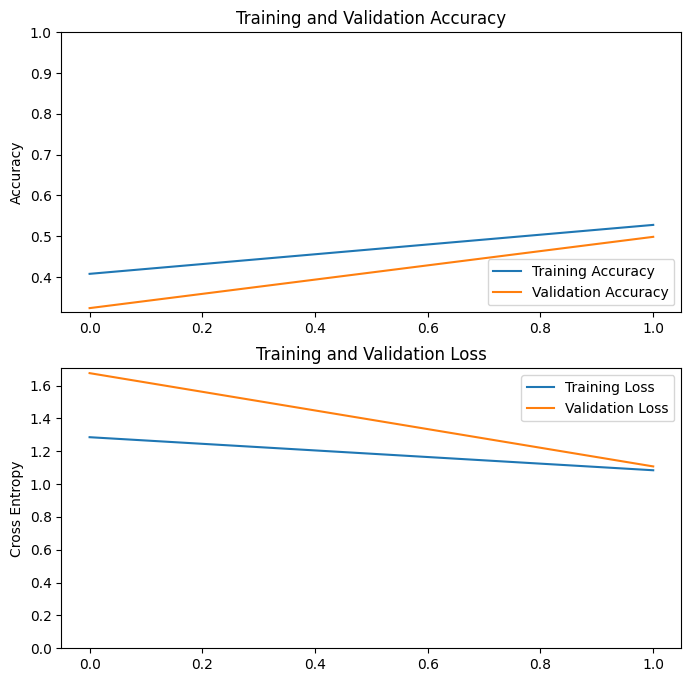

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

#### Confusion Matrix

147/147 [==============================] - 191s 1s/step


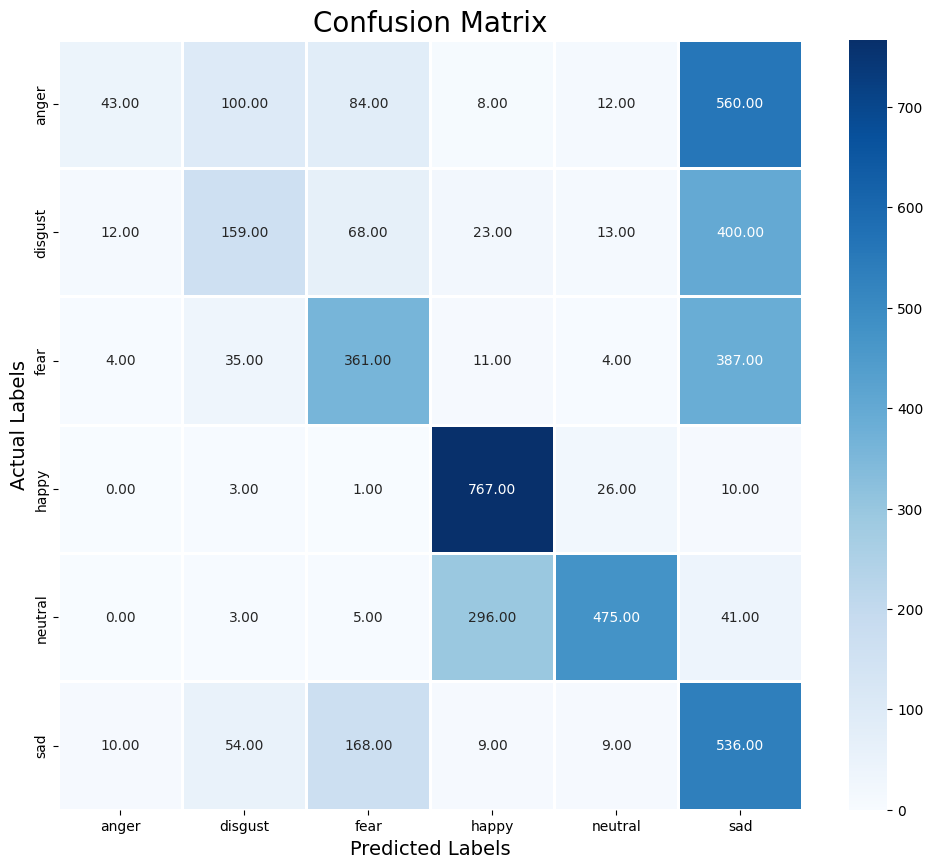

              precision    recall  f1-score   support

           0       0.62      0.05      0.10       807
           1       0.45      0.24      0.31       675
           2       0.53      0.45      0.48       802
           3       0.69      0.95      0.80       807
           4       0.88      0.58      0.70       820
           5       0.28      0.68      0.39       786

    accuracy                           0.50      4697
   macro avg       0.57      0.49      0.46      4697
weighted avg       0.58      0.50      0.47      4697



In [16]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
valid_pres=customModel.predict(x_val)
valid_pred = [np.argmax(pred) for pred in valid_pres]
y_val = np.argmax(y_val, axis=1)
cm =confusion_matrix(y_val,valid_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in class_names] , columns = [i for i in class_names])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_val,valid_pred))

In [ ]:
#2347

### VGG

In [17]:
# download the data from g drive

import gdown
url = "https://drive.google.com/file/d/12jiQxJzYSYl3wnC8x5wHAhRzzJmmsCXP/view?usp=sharing"
file_id = url.split("/")[-2]
print(file_id)
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix+file_id, "catdog.zip")

12jiQxJzYSYl3wnC8x5wHAhRzzJmmsCXP


Downloading...
From: https://drive.google.com/uc?/export=download&id=12jiQxJzYSYl3wnC8x5wHAhRzzJmmsCXP
To: c:\Users\VAIBHAV\Downloads\Project\catdog.zip
100%|██████████| 9.09M/9.09M [00:08<00:00, 1.13MB/s]


'catdog.zip'

In [39]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the base model as a layer
model.add(base_model)

# Add custom layers on top of the base model
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # Use 'softmax' activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [38]:
y_train.shape
# y_val = keras.utils.to_categorical(y_val, 6)

(18786, 6)

In [40]:
# Train the model
history=model.fit(
    x_train,y_train,
    epochs=2,
    validation_data=(x_val,y_val))

Epoch 1/2
588/588 [==============================] - 501s 848ms/step - loss: 1.5487 - accuracy: 0.3507 - val_loss: 1.4092 - val_accuracy: 0.4090
Epoch 2/2
588/588 [==============================] - 492s 836ms/step - loss: 1.4188 - accuracy: 0.3988 - val_loss: 1.3772 - val_accuracy: 0.4152


In [41]:
val_loss, val_acc = model.evaluate(x_val,y_val)
print('Validation accuracy : ', val_acc)

147/147 [==============================] - 94s 637ms/step - loss: 1.3772 - accuracy: 0.4152
Validation accuracy :  0.41515859961509705


In [42]:
score = model.evaluate(x_test, y_test)

184/184 [==============================] - 138s 751ms/step - loss: 1.3770 - accuracy: 0.4100


In [43]:
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 1.3769975900650024
Test accuracy: 0.40998125076293945


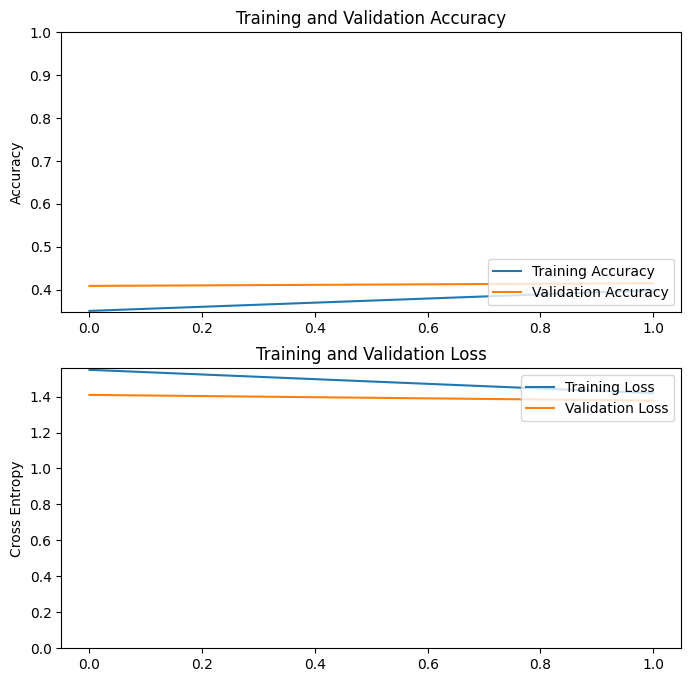

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

147/147 [==============================] - 96s 651ms/step


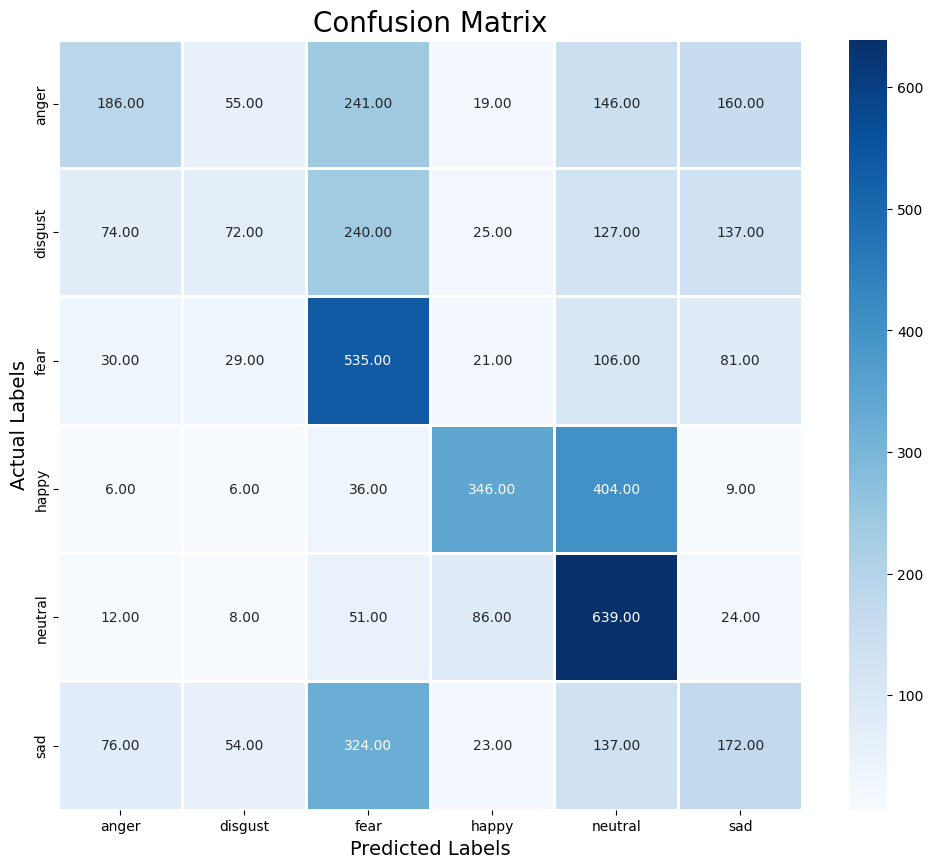

              precision    recall  f1-score   support

           0       0.48      0.23      0.31       807
           1       0.32      0.11      0.16       675
           2       0.37      0.67      0.48       802
           3       0.67      0.43      0.52       807
           4       0.41      0.78      0.54       820
           5       0.30      0.22      0.25       786

    accuracy                           0.42      4697
   macro avg       0.43      0.41      0.38      4697
weighted avg       0.43      0.42      0.38      4697



In [46]:
from sklearn.metrics import confusion_matrix,classification_report
valid_pres=model.predict(x_val)
valid_pred = [np.argmax(pred) for pred in valid_pres]
y_val = np.argmax(y_val, axis=1)
cm =confusion_matrix(y_val,valid_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in class_names] , columns = [i for i in class_names])
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_val,valid_pred))

In [ ]:
#1950

### ResNet

In [48]:
# Residual block
def residual_block(x, filters, downsample=False):
    strides = (2, 2) if downsample else (1, 1)

    # First convolutional layer of the block
    y = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Second convolutional layer of the block
    y = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    if downsample:
        x = Conv2D(filters, kernel_size=(1, 1), strides=(2, 2), padding='same')(x)

    # Add skip connection
    y = Add()([x, y])
    y = Activation('relu')(y)
    return y

# Build the ResNet model
def resnet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    x = residual_block(x, filters=16)
    x = residual_block(x, filters=16)
    x = residual_block(x, filters=32, downsample=True)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=64, downsample=True)
    x = residual_block(x, filters=64)
    

    # Average pooling and output layer
    x = AveragePooling2D(pool_size=(8, 8))(x)
    x = Flatten()(x)
    outputs = Dense(6, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
# # Residual block
# def residual_block(x, filters, downsample=False):
#     strides = (2, 2) if downsample else (1, 1)

#     # First convolutional layer of the block
#     y = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
#     y = BatchNormalization()(y)
#     y = Activation('relu')(y)

#     # Second convolutional layer of the block
#     y = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
#     y = BatchNormalization()(y)

#     if downsample:
#         x = Conv2D(filters, kernel_size=(1, 1), strides=(2, 2), padding='same')(x)

#     # Add skip connection
#     y = Add()([x, y])
#     y = Activation('relu')(y)
#     return y

# # Build the ResNet model
# def resnet(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)

#     # Initial convolutional layer
#     x = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     # Residual blocks
#     x = residual_block(x, filters=16)
#     x = residual_block(x, filters=16)
#     x = residual_block(x, filters=32, downsample=True)
#     x = residual_block(x, filters=32)
#     x = residual_block(x, filters=64, downsample=True)
#     x = residual_block(x, filters=64)
    

#     # Average pooling and output layer
#     x = AveragePooling2D(pool_size=(4, 4))(x)
#     x = Flatten()(x)
#     outputs = Dense(6, activation='softmax')(x)

#     model = Model(inputs=inputs, outputs=outputs)
#     return model

In [49]:
# Create the ResNet model
model = resnet(input_shape=(80, 80, 3), num_classes=6)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
history=model.fit(x_train, y_train, batch_size=64, epochs=2, verbose=1,validation_split=0.2, shuffle=True)

Epoch 1/2
235/235 [==============================] - 380s 2s/step - loss: 1.3635 - accuracy: 0.4154 - val_loss: 1.8508 - val_accuracy: 0.2219
Epoch 2/2
235/235 [==============================] - 396s 2s/step - loss: 1.0352 - accuracy: 0.5675 - val_loss: 1.2628 - val_accuracy: 0.4766


In [55]:
y_val.shape
# y_val = keras.utils.to_categorical(y_val, 6)

(4697, 6)

In [54]:
val_loss, val_acc = model.evaluate(x_val,y_val)
print('Validation accuracy : ', val_acc)

147/147 [==============================] - 23s 154ms/step - loss: 1.2683 - accuracy: 0.4741
Validation accuracy :  0.4741324186325073


In [56]:
score = model.evaluate(x_test, y_test)

184/184 [==============================] - 39s 210ms/step - loss: 1.2478 - accuracy: 0.4868


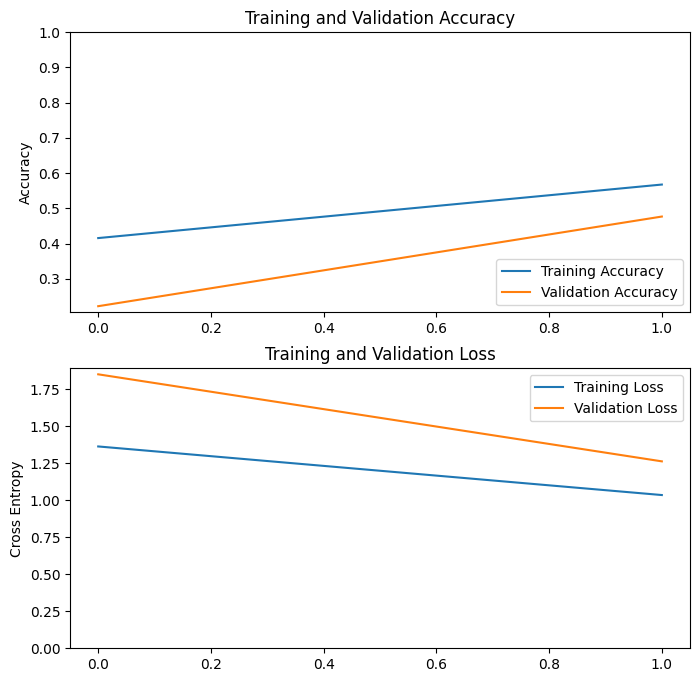

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

147/147 [==============================] - 33s 219ms/step


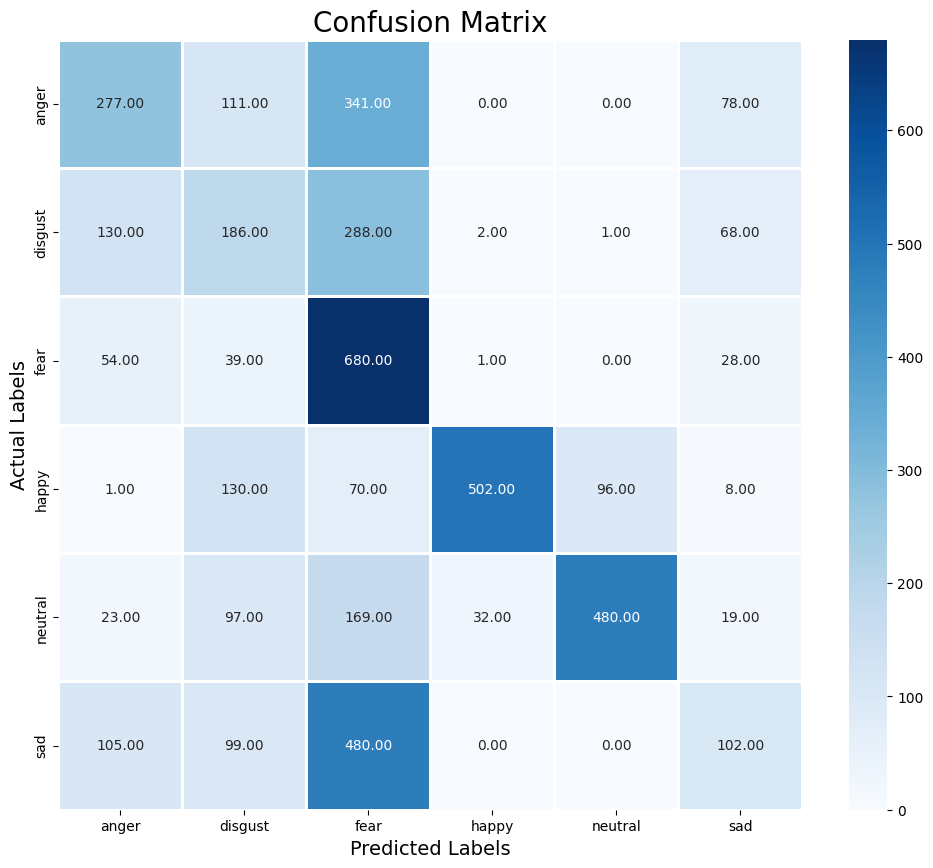

              precision    recall  f1-score   support

           0       0.47      0.34      0.40       807
           1       0.28      0.28      0.28       675
           2       0.34      0.85      0.48       802
           3       0.93      0.62      0.75       807
           4       0.83      0.59      0.69       820
           5       0.34      0.13      0.19       786

    accuracy                           0.47      4697
   macro avg       0.53      0.47      0.46      4697
weighted avg       0.54      0.47      0.47      4697



In [58]:
from sklearn.metrics import confusion_matrix,classification_report
valid_pres=model.predict(x_val)
valid_pred = [np.argmax(pred) for pred in valid_pres]
y_val = np.argmax(y_val, axis=1)
cm =confusion_matrix(y_val,valid_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in class_names] , columns = [i for i in class_names])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_val,valid_pred))

In [ ]:
#2227

### Inception

In [59]:
# download the data from g drive

import gdown
url = "https://drive.google.com/file/d/12jiQxJzYSYl3wnC8x5wHAhRzzJmmsCXP/view?usp=sharing"
file_id = url.split("/")[-2]
print(file_id)
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix+file_id, "catdog.zip")

12jiQxJzYSYl3wnC8x5wHAhRzzJmmsCXP


Downloading...
From: https://drive.google.com/uc?/export=download&id=12jiQxJzYSYl3wnC8x5wHAhRzzJmmsCXP
To: c:\Users\VAIBHAV\Downloads\Project\catdog.zip
100%|██████████| 9.09M/9.09M [00:09<00:00, 965kB/s] 


'catdog.zip'

In [60]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [61]:
# Load the InceptionV3 model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the base model as a layer
model.add(base_model)

# Add custom layers on top of the base model
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
y_val.shape
# y_val = keras.utils.to_categorical(y_val, 6)

(4697, 6)

In [66]:
# Train the model
history=model.fit(
    x_train,y_train,
    epochs=2,
    validation_data=(x_val,y_val))

Epoch 1/2
588/588 [==============================] - 122s 183ms/step - loss: 0.4329 - accuracy: 0.3167 - val_loss: 0.3938 - val_accuracy: 0.3822
Epoch 2/2
588/588 [==============================] - 89s 151ms/step - loss: 0.4002 - accuracy: 0.3764 - val_loss: 0.3847 - val_accuracy: 0.3890


In [67]:
val_loss, val_acc = model.evaluate(x_val,y_val)
print('Validation accuracy : ', val_acc)

147/147 [==============================] - 18s 122ms/step - loss: 0.3847 - accuracy: 0.3890
Validation accuracy :  0.3889716863632202


In [68]:
score = model.evaluate(x_test, y_test)

184/184 [==============================] - 26s 138ms/step - loss: 0.3847 - accuracy: 0.3858


In [69]:
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 0.38467296957969666
Test accuracy: 0.38579457998275757


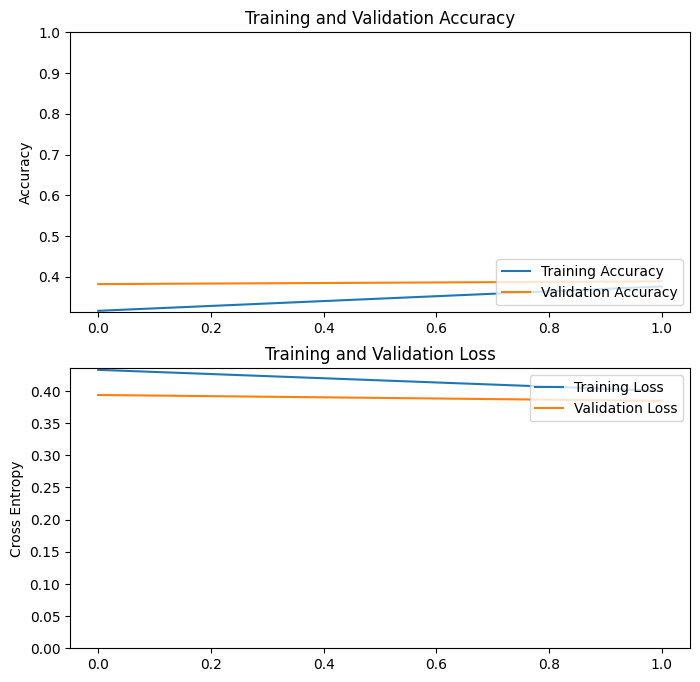

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

147/147 [==============================] - 22s 125ms/step


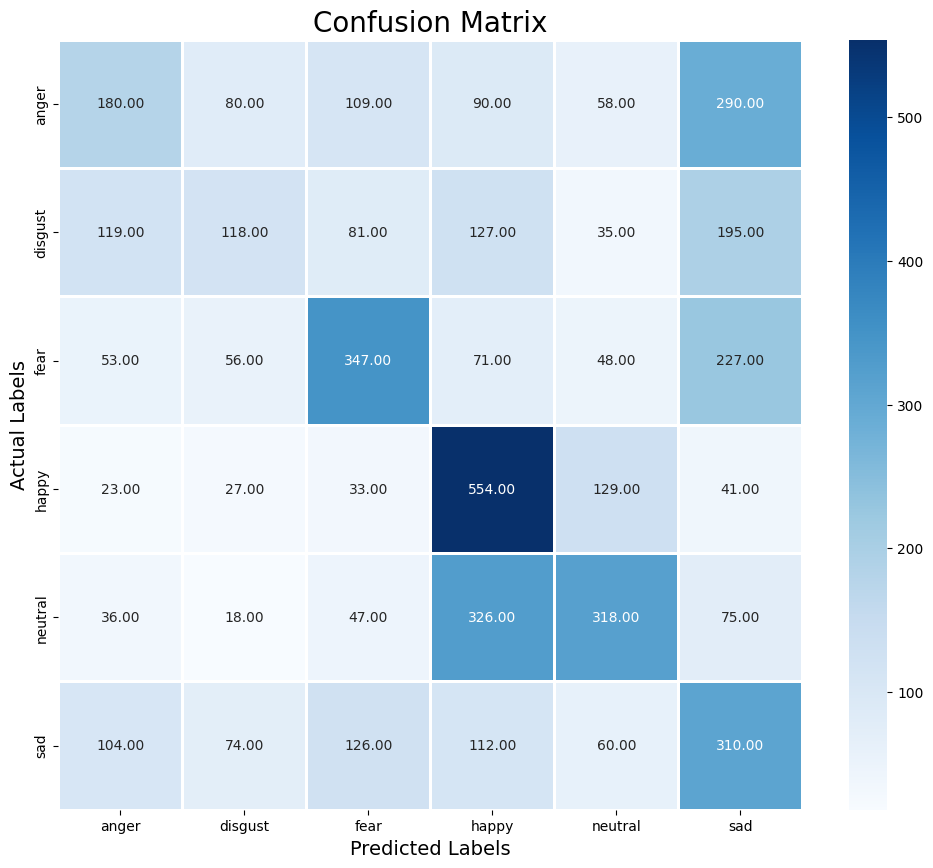

              precision    recall  f1-score   support

           0       0.35      0.22      0.27       807
           1       0.32      0.17      0.23       675
           2       0.47      0.43      0.45       802
           3       0.43      0.69      0.53       807
           4       0.49      0.39      0.43       820
           5       0.27      0.39      0.32       786

    accuracy                           0.39      4697
   macro avg       0.39      0.38      0.37      4697
weighted avg       0.39      0.39      0.38      4697



In [71]:
from sklearn.metrics import confusion_matrix,classification_report
valid_pres=model.predict(x_val)
valid_pred = [np.argmax(pred) for pred in valid_pres]
y_val = np.argmax(y_val, axis=1)
cm =confusion_matrix(y_val,valid_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in class_names] , columns = [i for i in class_names])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_val,valid_pred))

In [ ]:
# 1927

### Top Performing Models
 #### 1) Cnn - 2347 / 4697
 #### 2) Resnet - 2227 / 4697
 #### 3) Vgg - 1950 / 4697
 #### 4) Inception -1927 / 4697